# Intro to Superresolution

##Stuff to be written

In [1]:
%matplotlib inline
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.lines
from astropy.table import Table, Column
from scipy.optimize import curve_fit
from IPython.display import display, Math, Latex
import scipy.special

In [24]:
pi, np.pi

(3.141592653589793, 3.141592653589793)

In [21]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.5)

In [3]:
#sns.set_context()

Imports for the interactive widgets:

In [4]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import display, display_png, display_svg, clear_output
from IPython.core.pylabtools import print_figure

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
#Define points for later
xdist = arange(-80,80,0.1)
ydist = xdist

##Equation that dictates the ideal point spread function emmitted from a point dipole source

Here the equation:

$$
I(x,y) = \frac{\pi^4}{\epsilon_0^2 n n^\prime} \frac{\mu^2}{\lambda^6} \frac{NA^4}{M^2} \left[ \frac{J_1(2 \pi \tilde{\rho})}{2 \pi \tilde{\rho}} \right]^2, \space \space \tilde{\rho}= \frac{NA (x^2+y^2)}{M \lambda}
$$

Something inline $X$.

In [6]:
%%latex
\begin{aligned}
I(x,y) = \frac{\pi^4}{\epsilon_0^2 n n^\prime} \frac{\mu^2}{\lambda^6} \frac{NA^4}{M^2} \left[ \frac{J_1(2 \pi \tilde{\rho})}{2 \pi \tilde{\rho}} \right]^2, \space \space \tilde{\rho}= \frac{NA (x^2+y^2)}{M \lambda}
\end{aligned}

<IPython.core.display.Latex object>

###This is known as the Airy Function with J being a Bessel function of the first kind

In [7]:
# Define a few parameters for the Airy Function

# Universal Constants
epsilon_0 = 1 # Permitivity of Free Space (assuming atomic units)

# Experimental Constants
mu = 1        # Dipole Moment (dependent on which dye is used)
NA = 1.4      # Numerical Aperature
l  = 600      # Wavelength in nm
n  = 1.518    #index of refraction of material surrounding emmitter
n_prime = 1.518 #index of refraction of objective
M  = 60       # Magnification (60x)

# Function
xx, yy = meshgrid(xdist, ydist, sparse=True) # Prepares Grid Points
rho = np.sqrt(xx**2+yy**2) # Distance from center
rho_tilde = 500*rho*NA/(M*l) # The 500 is just a scaling factor

#I_0 = (math.pi**4/(epsilon_0*n*n_prime))*(mu**2/l**6)*(NA**4/M**2)  # Represents the number of photons we recieve

I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially

#I = (2*scipy.special.jv(1,2*math.pi*rho_tilde)/(2*math.pi*rho_tilde))**2 #Represents where we recieve the photons spatially



xdata = arange(0,5,0.1)

def fexp(x,a,b,c):
    return a*exp(-b*x)+c

def fgau(x,a,b,c):
    return a*exp(-(x-b)**2/(2*c**2))

def ddata(x,ns):
    noise = ns*randn(len(x))
    return fexp(x,2.5,1.3,0.5) + noise

ydata = ddata(xdata,0.2)

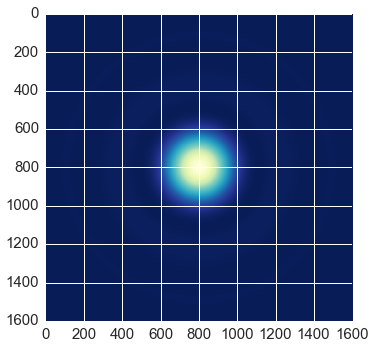

In [22]:
#h = plt.contourf(xdist,ydist,I)
imshow(I, cmap='YlGnBu_r', interpolation='nearest');

Check colormaps here: http://matplotlib.org/users/colormaps.html

##It is easier to visualize on a single axis. Let's choose the x-axis

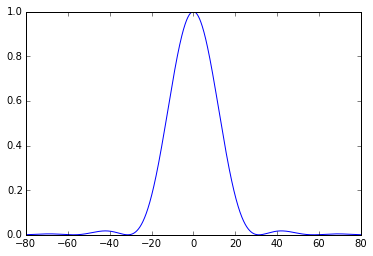

In [7]:
plot(xdist,I[I.shape[1]/2,:])

##Fit Gaussian to our Airy Function


Normalization      FWHM           Center     
------------- ------------- -----------------
1.01728339172 46.4296620048 1.54831181316e-07

  Norm std dev    FWHM std dev   Center std dev
---------------- -------------- ---------------
0.00108848030898 0.013365892944 0.0140577066533

Gau fit parameters      1.017  0.000 10.818
Gau fit std dev         0.001  0.014  0.013


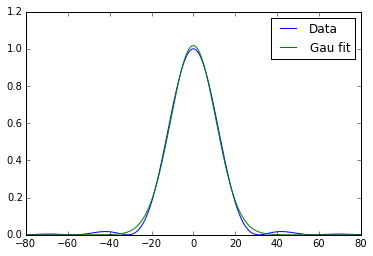

In [8]:
pg,cg = curve_fit(fgau,xdist,I[I.shape[1]/2,:])

ygau = fgau(xdist,*pg)

plot(xdist,I[I.shape[1]/2,:],'b-',label='Data')

plot(xdist,ygau,'g-',label='Gau fit')
legend()
print ''
t = Table()
t['Normalization'] = [pg[0]]
t['FWHM'] = [2.0*math.sqrt(2.0*math.log(10.0))*pg[2]]
t['Center'] = [pg[1]]
print t

print ''

tstddev = Table()
tstddev['Norm std dev'] = [sqrt(diag(cg))[0]]
tstddev['FWHM std dev'] = [sqrt(diag(cg))[2]]
tstddev['Center std dev'] = [sqrt(diag(cg))[1]]
print tstddev

print ''

print 'Gau fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pg)
print 'Gau fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cg)))

But real life experiments cannot obtain infinite resolution. We are limited by the tools that we have. In our case of a collecting photons from a point dipole source, we a limited in our spatial resolution by our pixels.

array([-80.        , -69.33333333, -58.66666667, -48.        ,
       -37.33333333, -26.66666667, -16.        ,  -5.33333333,
         5.33333333,  16.        ,  26.66666667,  37.33333333,
        48.        ,  58.66666667,  69.33333333,  80.        ])

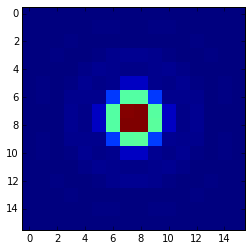

In [9]:
pixel = I.reshape(16,100,16,100)
pixel = pixel.sum(axis=3).sum(axis=1)
xpixel = linspace(-80,80,16)
ypixel = xpixel
imshow(pixel,interpolation = 'nearest')
xpixel

<Container object of 16 artists>

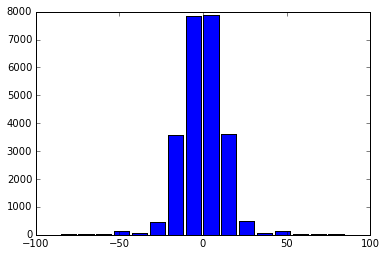

In [10]:
centerpixel = xpixel-5
bar(centerpixel,pixel[pixel.shape[1]/2,:],width=9)


Normalization      FWHM          Center    
------------- ------------- ---------------
8738.93691773 50.5637364947 0.0533051165624

 Norm std dev  FWHM std dev  Center std dev
------------- -------------- --------------
92.2383441595 0.143707878429 0.143482230034

Gau fit parameters     8738.937  0.053 11.781
Gau fit std dev        92.238  0.143  0.144


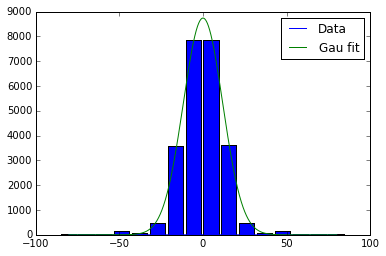

In [11]:
pg,cg = curve_fit(fgau,xpixel,pixel[pixel.shape[1]/2,:])

ygau = fgau(xdist,*pg)


bar(centerpixel,pixel[pixel.shape[1]/2,:],width=9)
plot(xdist,I[I.shape[1]/2,:],'b-',label='Data')

plot(xdist,ygau,'g-',label='Gau fit')
legend()

print ''
t = Table()
t['Normalization'] = [pg[0]]
t['FWHM'] = [2.0*math.sqrt(2.0*math.log(10.0))*pg[2]]
t['Center'] = [pg[1]]
print t

print ''

tstddev = Table()
tstddev['Norm std dev'] = [sqrt(diag(cg))[0]]
tstddev['FWHM std dev'] = [sqrt(diag(cg))[2]]
tstddev['Center std dev'] = [sqrt(diag(cg))[1]]
print tstddev

print ''

print 'Gau fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pg)
print 'Gau fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cg)))

##Noise

Unfortunately, this is still very ideal. There can be noise in our system from other sources (autoflourecense, scattering, or  photons from a nearby lightsource leaking into our sample box. For now, we will simply the problem by looking at a single image in a movie.

<Container object of 16 artists>

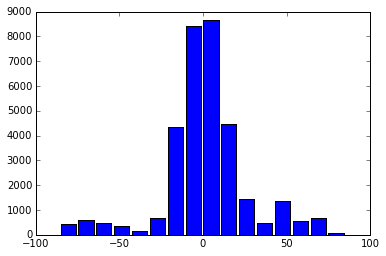

In [12]:
noise = np.random.normal(loc=500.0,scale=500.0,size=(16,16))
pixelnoise = pixel + abs(noise)
bar(centerpixel,pixelnoise[pixelnoise.shape[1]/2,:],width=9)


Normalization      FWHM         Center    
------------- ------------- --------------
9286.74569812 56.2073197557 0.510369917435

 Norm std dev  FWHM std dev  Center std dev
------------- -------------- --------------
451.579276611 0.735389968283 0.735289817714



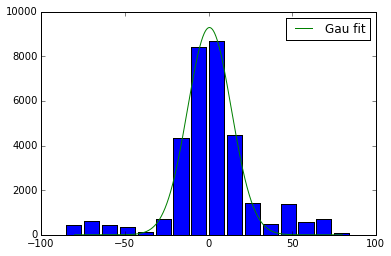

In [13]:
pg,cg = curve_fit(fgau,xpixel,pixelnoise[pixelnoise.shape[1]/2,:])

ygau = fgau(xdist,*pg)


bar(centerpixel,pixelnoise[pixelnoise.shape[1]/2,:],width=9)
plot(xdist,ygau,'g-',label='Gau fit')
legend()

print ''
t = Table()
t['Normalization'] = [pg[0]]
t['FWHM'] = [2.0*math.sqrt(2.0*math.log(10.0))*pg[2]]
t['Center'] = [pg[1]]
print t

print ''

tstddev = Table()
tstddev['Norm std dev'] = [sqrt(diag(cg))[0]]
tstddev['FWHM std dev'] = [sqrt(diag(cg))[2]]
tstddev['Center std dev'] = [sqrt(diag(cg))[1]]
print tstddev

print ''


#Finding Standard Deviation of Center

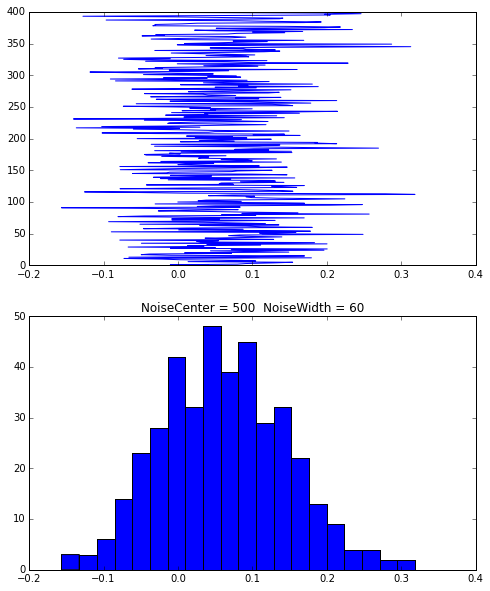

In [20]:
@interact(NoiseCenter = (100, 500, 10), NoiseWidth = (10, 200, 10))
def plot_noise(NoiseCenter=500.0, NoiseWidth=200.0):
    sample = 400
    Average = 1
    
    noise_all = np.random.normal(loc=NoiseCenter, scale=NoiseWidth, size=(sample, 16, 16))
    pos = np.zeros(shape=(sample))
    for n in range(0, sample):
        noise = noise_all[n]
        pixelnoise = pixel + abs(noise)
        pg,cg = curve_fit(fgau,xpixel,pixelnoise[pixelnoise.shape[1]/2,:])
        pos[n]=pg[1]

    poshist, posedge = histogram(pos,20)

    plt.figure(1,figsize=(8, 10))
    plt.subplot(211)
    plt.plot(pos,range(0,sample))

    plt.subplot(212)
    plt.hist(pos,20)
    plt.title('NoiseCenter = %d  NoiseWidth = %d' % (NoiseCenter, NoiseWidth))
    
    # Hack that may not be needed anymore
    #fig = gcf()
    #plt.close()
    #display(fig)

See also: http://stackoverflow.com/questions/24961674/ipython-notebook-widgets-for-matplotlib-interactivity

In [15]:
%load_ext line_profiler

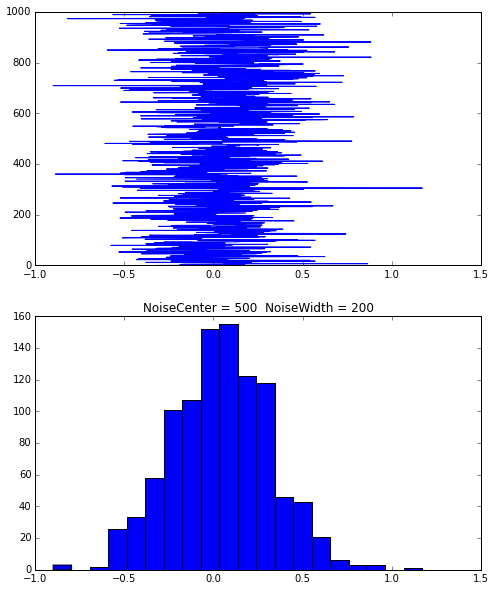

In [17]:
%lprun -f plot_noise plot_noise()

In [ ]:
sample = 10000
Average = 1
NoiseCenter = 500.0
NoiseWidth = 200.0

pos = np.zeros(shape=(sample))
for n in range(0,sample):
    noise = np.random.normal(loc=NoiseCenter,scale=NoiseWidth,size=(16,16))
    pixelnoise = pixel + abs(noise)
    pg,cg = curve_fit(fgau,xpixel,pixelnoise[pixelnoise.shape[1]/2,:])
    pos[n]=pg[1]


poshist, posedge = histogram(pos,20)
# TO FINISH AVERAGING LATER
#pixel = I.reshape(16,100,16,100)
#pixel = pixel.sum(axis=3).sum(axis=1)
#xpixel = linspace(-80,80,16)

In [13]:
plt.figure(1,figsize=(8, 20))
plt.subplot(211)
plt.plot(pos,range(0,sample))

plt.subplot(212)
plt.hist(pos,20)
plt.show()

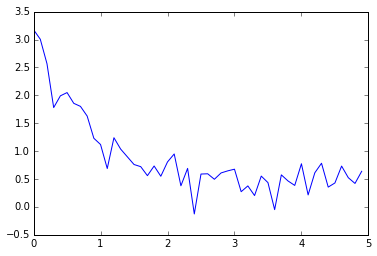

In [15]:
plot(xdata,ydata)

Fit data to exp and gau curves

In [16]:
pe,ce = curve_fit(fexp,xdata,ydata)
pg,cg = curve_fit(fgau,xdata,ydata)
yexp = fexp(xdata,*pe)
ygau = fgau(xdata,*pg)
    
plot(xdata,ydata,'-sb',ls=':',label='Data')

plot(xdata,yexp,'r-',label='Exp fit')
plot(xdata,ygau,'g-',label='Gau fit')
legend()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Print Fit Parameters

In [ ]:
print 'Exp fit params         {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pe)
print 'Exp fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(ce)))
print 'Gau fit parameters     {0:6.3f} {1:6.3f} {2:6.3f}'.format(*pg)
print 'Gau fit std dev        {0:6.3f} {1:6.3f} {2:6.3f}'.format(*sqrt(diag(cg)))